In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*70)
print("GPU-ACCELERATED NCAA TOURNAMENT PREDICTION MODEL")
print("="*70)

# Load the data
df = pd.read_csv('men_2026_matchups_training.csv')

# Filter for Second Round games only
df_second_round = df[df['round'] == 'Second Round'].copy()

print(f"\nTotal Second Round games: {len(df_second_round)}")
print(f"Class distribution:\n{df_second_round['win'].value_counts()}")


GPU-ACCELERATED NCAA TOURNAMENT PREDICTION MODEL

Total Second Round games: 320
Class distribution:
win
1    160
0    160
Name: count, dtype: int64


In [2]:
# Define features
features = [
    '5man_bpm',
    'kenpom_rtg',
    'def_lineup_depth_quality',
    'torvik_rtg',
    'kenpom_off',
    '3man_bpm',
    '5man_dbpm',
    'lineup_depth_quality',
    '5man_obpm',
    'kenpom_def',
    'experience_weighted_production',
    'wab',
    'defensive_versatility_score',
    'four_factors_composite',
    'torvik_def',
    '3man_obpm',
    'off_3pt_fg_pct',
    'def_four_factors_composite',
    'torvik_off',
    'size_speed_index',
    'def_size_speed_index',
    'def_rim_efficiency',
    'def_experience_impact',
    'efg_pct',
    'offensive_versatility_score',
    'efgd_pct',
    '3pd_pct',
    'def_3pt_fg_pct',
    'blk_pct',
    'blked_pct'
]

# Prepare X and y
X = df_second_round[features]
y = df_second_round['win']

# Check for missing values
print(f"\nMissing values:\n{X.isnull().sum()[X.isnull().sum() > 0]}")

# Handle missing values
X = X.fillna(X.median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Missing values:
Series([], dtype: int64)

Training set size: 256
Test set size: 64


In [3]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# =============================================================================
# STAGE 1: BROAD SEARCH
# =============================================================================
print("\n" + "="*80)
print("STAGE 1: BROAD HYPERPARAMETER SEARCH")
print("Iterations: 200 | CV Folds: 5 | Total Fits: 1,000")
print("="*80 + "\n")

param_distributions_stage1 = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 15, 20],
    'max_features': ['sqrt', 'log2', 0.3, 0.4, 0.5, 0.6, 0.7],
    'bootstrap': [True, False],
    'max_samples': [0.6, 0.7, 0.8, 0.9, 1.0],
}

rf_stage1 = RandomForestClassifier(random_state=42, n_jobs=-1, warm_start=False)

random_search_stage1 = RandomizedSearchCV(
    estimator=rf_stage1,
    param_distributions=param_distributions_stage1,
    n_iter=200,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

stage1_start = time.time()
random_search_stage1.fit(X_train_scaled, y_train)
stage1_time = time.time() - stage1_start

best_params_stage1 = random_search_stage1.best_params_

print(f"\n{'='*80}")
print(f"STAGE 1 COMPLETE - Time: {stage1_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage1.items():
    print(f"  {param}: {value}")



STAGE 1: BROAD HYPERPARAMETER SEARCH
Iterations: 200 | CV Folds: 5 | Total Fits: 1,000

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
560 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
560 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py", line 431, in fit
    raise ValueError(
ValueEr


STAGE 1 COMPLETE - Time: 8.3 minutes
Best CV Score: 0.7774

Best Parameters:
  n_estimators: 500
  min_samples_split: 5
  min_samples_leaf: 4
  max_samples: 0.6
  max_features: 0.5
  max_depth: 10
  bootstrap: True


In [5]:
# =============================================================================
# STAGE 2: FOCUSED SEARCH
# =============================================================================
print("\n" + "="*80)
print("STAGE 2: FOCUSED SEARCH AROUND BEST PARAMS")
print("Iterations: 1,000 | CV Folds: 5 | Total Fits: 5,000")
print("="*80 + "\n")

def get_range(value, options_list, expand_by=2):
    """Get a focused range around the best value"""
    if value is None:
        return [None]
    if value not in options_list:
        return [value]

    idx = options_list.index(value)
    start_idx = max(0, idx - expand_by)
    end_idx = min(len(options_list), idx + expand_by + 1)
    return options_list[start_idx:end_idx]

n_estimators_opts = [100, 200, 300, 500, 700, 1000, 1500]
max_depth_opts = [3, 4, 5, 6, 7, 8, 10, 12, 15, None]
min_samples_split_opts = [2, 5, 10, 15, 20, 25, 30, 40, 50]
min_samples_leaf_opts = [1, 2, 4, 6, 8, 10, 15, 20, 25]
max_features_opts = ['sqrt', 'log2', 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
max_samples_opts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

param_distributions_stage2 = {
    'n_estimators': get_range(best_params_stage1['n_estimators'], n_estimators_opts, 2),
    'max_depth': get_range(best_params_stage1['max_depth'], max_depth_opts, 2),
    'min_samples_split': get_range(best_params_stage1['min_samples_split'], min_samples_split_opts, 3),
    'min_samples_leaf': get_range(best_params_stage1['min_samples_leaf'], min_samples_leaf_opts, 3),
    'max_features': get_range(best_params_stage1['max_features'], max_features_opts, 3),
    'bootstrap': [best_params_stage1['bootstrap']],
    'max_samples': get_range(best_params_stage1.get('max_samples'), max_samples_opts, 3) if best_params_stage1['bootstrap'] else [1.0],
}

print(f"Stage 2 Search Space:")
for param, values in param_distributions_stage2.items():
    print(f"  {param}: {values}")

rf_stage2 = RandomForestClassifier(random_state=42, n_jobs=-1, warm_start=False)

random_search_stage2 = RandomizedSearchCV(
    estimator=rf_stage2,
    param_distributions=param_distributions_stage2,
    n_iter=1000,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=43,
    return_train_score=True
)

stage2_start = time.time()
random_search_stage2.fit(X_train_scaled, y_train)
stage2_time = time.time() - stage2_start

best_params_stage2 = random_search_stage2.best_params_

print(f"\n{'='*80}")
print(f"STAGE 2 COMPLETE - Time: {stage2_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage2.best_score_:.4f}")
print(f"Improvement from Stage 1: {random_search_stage2.best_score_ - random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage2.items():
    print(f"  {param}: {value}")


STAGE 2: FOCUSED SEARCH AROUND BEST PARAMS
Iterations: 1,000 | CV Folds: 5 | Total Fits: 5,000

Stage 2 Search Space:
  n_estimators: [200, 300, 500, 700, 1000]
  max_depth: [7, 8, 10, 12, 15]
  min_samples_split: [2, 5, 10, 15, 20]
  min_samples_leaf: [1, 2, 4, 6, 8, 10]
  max_features: [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
  bootstrap: [True]
  max_samples: [0.6, 0.65, 0.7, 0.75]
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits

STAGE 2 COMPLETE - Time: 111.5 minutes
Best CV Score: 0.7773
Improvement from Stage 1: -0.0001

Best Parameters:
  n_estimators: 300
  min_samples_split: 10
  min_samples_leaf: 4
  max_samples: 0.75
  max_features: 0.35
  max_depth: 15
  bootstrap: True


In [6]:
# =============================================================================
# STAGE 3: FINE-TUNING
# =============================================================================
print("\n" + "="*80)
print("STAGE 3: FINE-TUNING WITH 10-FOLD CV")
print("Iterations: 2,000 | CV Folds: 10 | Total Fits: 20,000")
print("="*80 + "\n")

param_distributions_stage3 = {
    'n_estimators': get_range(best_params_stage2['n_estimators'], n_estimators_opts, 1),
    'max_depth': get_range(best_params_stage2['max_depth'], max_depth_opts, 1),
    'min_samples_split': get_range(best_params_stage2['min_samples_split'], min_samples_split_opts, 2),
    'min_samples_leaf': get_range(best_params_stage2['min_samples_leaf'], min_samples_leaf_opts, 2),
    'max_features': get_range(best_params_stage2['max_features'], max_features_opts, 2),
    'bootstrap': [best_params_stage2['bootstrap']],
    'max_samples': get_range(best_params_stage2.get('max_samples'), max_samples_opts, 2) if best_params_stage2['bootstrap'] else [1.0],
}

print(f"Stage 3 Search Space:")
for param, values in param_distributions_stage3.items():
    print(f"  {param}: {values}")

rf_stage3 = RandomForestClassifier(random_state=42, n_jobs=-1, warm_start=False)

random_search_stage3 = RandomizedSearchCV(
    estimator=rf_stage3,
    param_distributions=param_distributions_stage3,
    n_iter=2000,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=44,
    return_train_score=True
)

stage3_start = time.time()
random_search_stage3.fit(X_train_scaled, y_train)
stage3_time = time.time() - stage3_start

print(f"\n{'='*80}")
print(f"STAGE 3 COMPLETE - Time: {stage3_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage3.best_score_:.4f}")
print(f"Improvement from Stage 2: {random_search_stage3.best_score_ - random_search_stage2.best_score_:.4f}")
print(f"\nFinal Best Parameters:")
for param, value in random_search_stage3.best_params_.items():
    print(f"  {param}: {value}")

# Get the best model from Stage 3
best_rf = random_search_stage3.best_estimator_

# Verify the model has feature_importances_
if not hasattr(best_rf, 'feature_importances_'):
    print("\n⚠️  WARNING: Model missing feature_importances_. Re-fitting...")
    best_rf.fit(X_train_scaled, y_train)


STAGE 3: FINE-TUNING WITH 10-FOLD CV
Iterations: 2,000 | CV Folds: 10 | Total Fits: 20,000

Stage 3 Search Space:
  n_estimators: [200, 300, 500]
  max_depth: [12, 15, None]
  min_samples_split: [2, 5, 10, 15, 20]
  min_samples_leaf: [1, 2, 4, 6, 8]
  max_features: [0.25, 0.3, 0.35, 0.4, 0.45]
  bootstrap: [True]
  max_samples: [0.65, 0.7, 0.75, 0.8, 0.85]
Fitting 10 folds for each of 2000 candidates, totalling 20000 fits

STAGE 3 COMPLETE - Time: 275.0 minutes
Best CV Score: 0.7814
Improvement from Stage 2: 0.0041

Final Best Parameters:
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 1
  max_samples: 0.65
  max_features: 0.4
  max_depth: 12
  bootstrap: True


In [7]:
# =============================================================================
# FINAL EVALUATION
# =============================================================================
print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80 + "\n")

# Evaluate on training set
y_train_pred = best_rf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate on test set
y_test_pred = best_rf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Performance Across All Stages:")
print(f"  Stage 1 CV Score: {random_search_stage1.best_score_:.4f}")
print(f"  Stage 2 CV Score: {random_search_stage2.best_score_:.4f}")
print(f"  Stage 3 CV Score: {random_search_stage3.best_score_:.4f}")
print(f"  Total Improvement: {random_search_stage3.best_score_ - random_search_stage1.best_score_:.4f}")

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {train_accuracy:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Difference (Overfitting Check): {train_accuracy - test_accuracy:.4f}")

if train_accuracy - test_accuracy > 0.10:
    print("\n⚠️  SEVERE WARNING: Significant overfitting detected!")
elif train_accuracy - test_accuracy > 0.05:
    print("\n⚠️  WARNING: Model may be overfitting (train-test gap > 5%)")
else:
    print("\n✓ Model appears to generalize well")



FINAL MODEL EVALUATION

Performance Across All Stages:
  Stage 1 CV Score: 0.7774
  Stage 2 CV Score: 0.7773
  Stage 3 CV Score: 0.7814
  Total Improvement: 0.0040

Final Model Performance:
  Training Accuracy: 0.9570
  Test Accuracy: 0.8125
  Difference (Overfitting Check): 0.1445

⚠️  SEVERE WARNING: Significant overfitting detected!


In [8]:
# Detailed classification report
print(f"\n{'='*80}")
print("Classification Report (Test Set):")
print("="*80)
print(classification_report(y_test, y_test_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        32
           1       0.78      0.88      0.82        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64



In [9]:
# Confusion Matrix
print(f"\n{'='*80}")
print("Confusion Matrix:")
print("="*80)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


Confusion Matrix:
[[24  8]
 [ 4 28]]


In [10]:
# Cross-validation scores
print(f"\n{'='*80}")
print("Cross-Validation Stability Check (10-fold):")
print("="*80)
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=10, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Std CV Score: {cv_scores.std():.4f}")

if cv_scores.std() > 0.05:
    print("\n⚠️  WARNING: High CV variance - model may be unstable")
else:
    print("\n✓ Model shows stable performance across folds")


Cross-Validation Stability Check (10-fold):
CV Scores: [0.76923077 0.80769231 0.69230769 0.80769231 0.88461538 0.69230769
 0.84       0.72       0.84       0.76      ]
Mean CV Score: 0.7814
Std CV Score: 0.0626

⚠️  WARNING: High CV variance - model may be unstable



Feature Importance Analysis:

Top 15 Most Important Features:
                    feature  importance
                   5man_bpm    0.163318
                 torvik_rtg    0.117267
                 kenpom_rtg    0.095750
                   3man_bpm    0.042222
                  5man_obpm    0.035462
                        wab    0.034102
                  5man_dbpm    0.032736
offensive_versatility_score    0.032213
         def_rim_efficiency    0.031050
       def_size_speed_index    0.028314
           size_speed_index    0.028279
      def_experience_impact    0.028268
defensive_versatility_score    0.027555
       lineup_depth_quality    0.025146
             off_3pt_fg_pct    0.024029


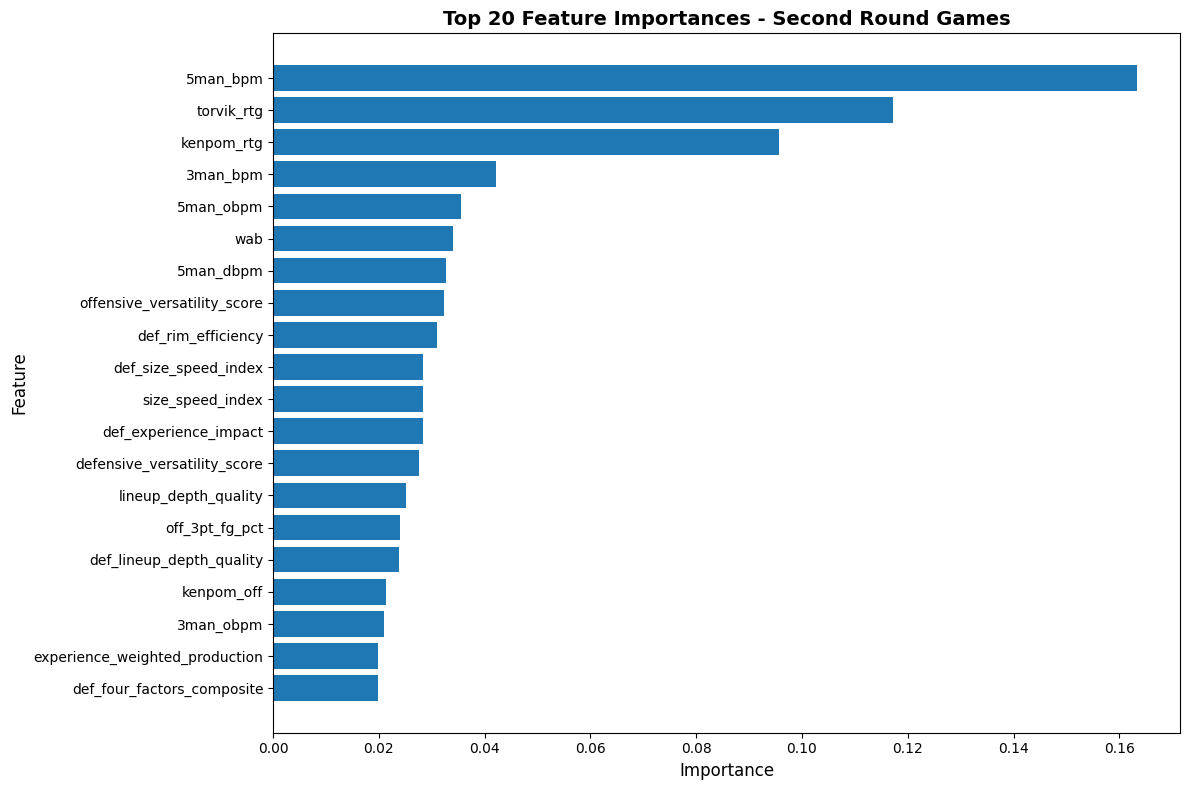

In [11]:
# Feature importance - with error handling
print(f"\n{'='*80}")
print("Feature Importance Analysis:")
print("="*80)

try:
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 20 Feature Importances - Second Round Games', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"\n⚠️  Error getting feature importances: {e}")
    print("Continuing with analysis...")

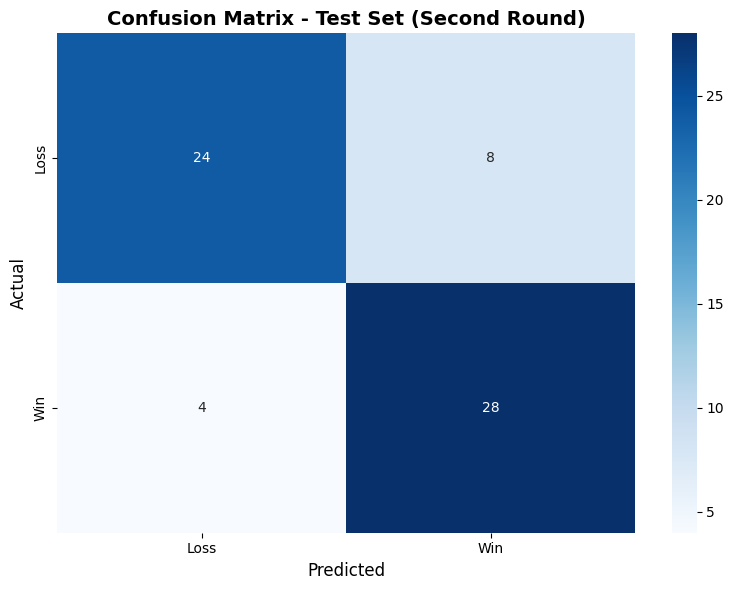

In [12]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix - Test Set (Second Round)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()


Generating Learning Curves...


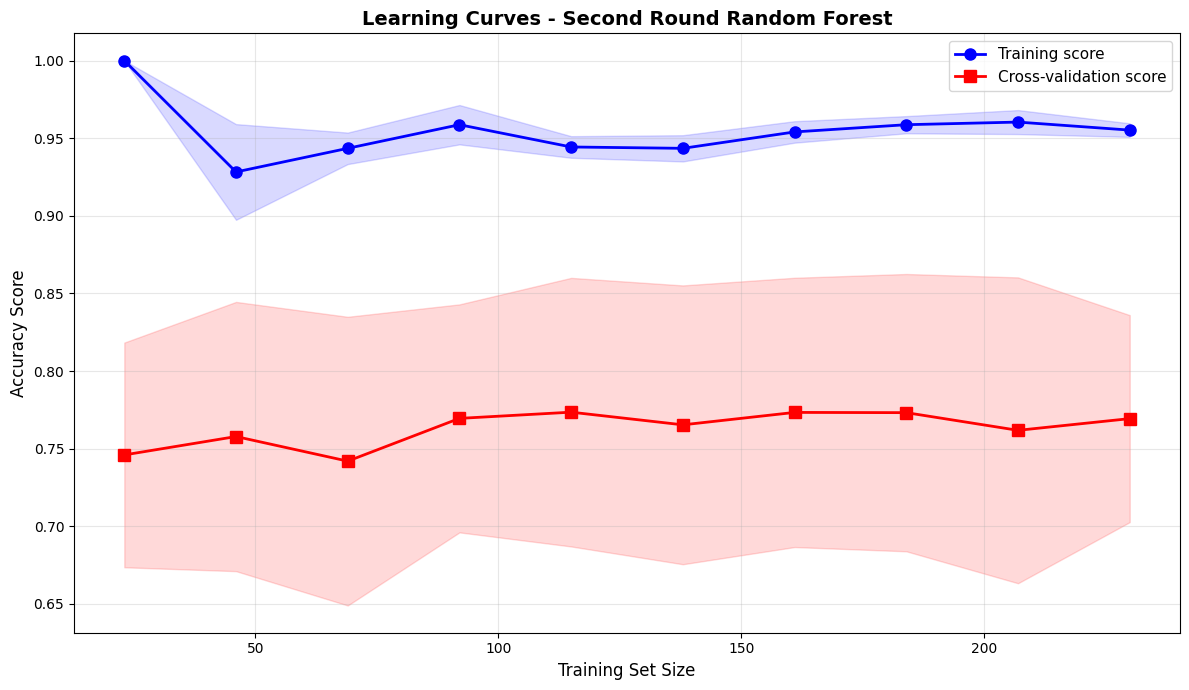

In [13]:
# Learning curves
from sklearn.model_selection import learning_curve

print(f"\n{'='*80}")
print("Generating Learning Curves...")
print("="*80)

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_scaled, y_train,
    cv=10, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    verbose=0
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o', linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='s', linewidth=2, markersize=8)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Learning Curves - Second Round Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Analysis of learning curves
print(f"\n{'='*80}")
print("Learning Curve Analysis:")
print("="*80)
final_train_mean = train_mean[-1]
final_val_mean = val_mean[-1]
gap = final_train_mean - final_val_mean

print(f"Final training score: {final_train_mean:.4f}")
print(f"Final validation score: {final_val_mean:.4f}")
print(f"Gap: {gap:.4f}")

if gap > 0.1:
    print("\n⚠️  High variance/overfitting: Training score much higher than validation")
    print("   → Consider: more data, stronger regularization")
elif final_val_mean < 0.65:
    print("\n⚠️  High bias/underfitting: Low validation score overall")
    print("   → Consider: more complex model, more features")
else:
    print("\n✓ Model shows good bias-variance tradeoff")



Learning Curve Analysis:
Final training score: 0.9552
Final validation score: 0.7694
Gap: 0.1858

⚠️  High variance/overfitting: Training score much higher than validation
   → Consider: more data, stronger regularization


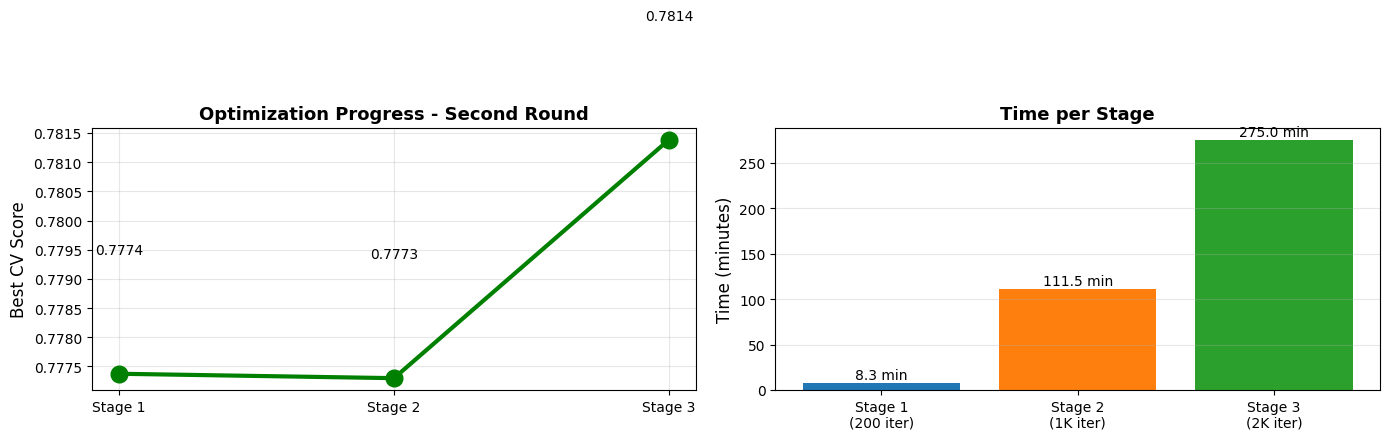

In [15]:
# Stage comparison plot
stage_scores = [
    random_search_stage1.best_score_,
    random_search_stage2.best_score_,
    random_search_stage3.best_score_
]
stage_times = [stage1_time/60, stage2_time/60, stage3_time/60]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(['Stage 1', 'Stage 2', 'Stage 3'], stage_scores, marker='o', linewidth=3, markersize=12, color='green')
ax1.set_ylabel('Best CV Score', fontsize=12)
ax1.set_title('Optimization Progress - Second Round', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
for i, score in enumerate(stage_scores):
    ax1.text(i, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=10)

ax2.bar(['Stage 1\n(200 iter)', 'Stage 2\n(1K iter)', 'Stage 3\n(2K iter)'], stage_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_ylabel('Time (minutes)', fontsize=12)
ax2.set_title('Time per Stage', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, t in enumerate(stage_times):
    ax2.text(i, t + 1, f'{t:.1f} min', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [16]:
# Summary statistics
total_time = stage1_time + stage2_time + stage3_time
total_combinations = 200 + 1000 + 2000
total_fits = (200 * 5) + (1000 * 5) + (2000 * 10)

print(f"\n{'='*80}")
print("FINAL SUMMARY - SECOND ROUND MODEL")
print("="*80)
print(f"Total combinations tested: {total_combinations:,}")
print(f"Total model fits: {total_fits:,}")
print(f"\nTime Breakdown:")
print(f"  Stage 1: {stage1_time/60:.1f} minutes")
print(f"  Stage 2: {stage2_time/60:.1f} minutes")
print(f"  Stage 3: {stage3_time/60:.1f} minutes")
print(f"  Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"\nOptimization Progress:")
print(f"  Stage 1 best score: {random_search_stage1.best_score_:.4f}")
print(f"  Stage 2 best score: {random_search_stage2.best_score_:.4f} (+{random_search_stage2.best_score_ - random_search_stage1.best_score_:.4f})")
print(f"  Stage 3 best score: {random_search_stage3.best_score_:.4f} (+{random_search_stage3.best_score_ - random_search_stage2.best_score_:.4f})")
print(f"  Total improvement: {random_search_stage3.best_score_ - random_search_stage1.best_score_:.4f}")
print(f"\nFinal Performance:")
print(f"  Best CV accuracy: {random_search_stage3.best_score_:.4f}")
print(f"  Test accuracy: {test_accuracy:.4f}")
print(f"  Train-test gap: {train_accuracy - test_accuracy:.4f}")
print(f"  CV stability (std): {cv_scores.std():.4f}")

if test_accuracy > 0.75:
    print(f"\n🏆 Model Performance: OUTSTANDING (>75% accuracy)")
elif test_accuracy > 0.70:
    print(f"\n🎯 Model Performance: EXCELLENT (>70% accuracy)")
elif test_accuracy > 0.65:
    print(f"\n✓ Model Performance: GOOD (>65% accuracy)")
elif test_accuracy > 0.60:
    print(f"\n⚠️  Model Performance: MODERATE (>60% accuracy)")
else:
    print(f"\n❌ Model Performance: NEEDS IMPROVEMENT (<60% accuracy)")

print("\n" + "="*80)
print("3-STAGE OPTIMIZATION COMPLETE! 🚀")
print("="*80)


FINAL SUMMARY - SECOND ROUND MODEL
Total combinations tested: 3,200
Total model fits: 26,000

Time Breakdown:
  Stage 1: 8.3 minutes
  Stage 2: 111.5 minutes
  Stage 3: 275.0 minutes
  Total time: 394.8 minutes (6.58 hours)

Optimization Progress:
  Stage 1 best score: 0.7774
  Stage 2 best score: 0.7773 (+-0.0001)
  Stage 3 best score: 0.7814 (+0.0041)
  Total improvement: 0.0040

Final Performance:
  Best CV accuracy: 0.7814
  Test accuracy: 0.8125
  Train-test gap: 0.1445
  CV stability (std): 0.0626

🏆 Model Performance: OUTSTANDING (>75% accuracy)

3-STAGE OPTIMIZATION COMPLETE! 🚀
